In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [62]:
#loading code modules containing some of the routines we wrote last time
#... so we don't have to write them again here! this is called "code reuse" :)

import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown


In [6]:
#ok let's load our usual data 
DATA_PATH = "/mnt/data3/yamins/visual/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [7]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]


In [8]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())


In [9]:
#now, let's actually import the Linear Support Vector Classifier (LinearSVC)
#from scikit
from sklearn.svm import LinearSVC

In [10]:
cat1 = 'Faces'
cat2 = 'Fruits'

results_svm_default = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                              )
    results_svm_default[vl] = results
    print('SVM Classifier Default Regulazation Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))



SVM Classifier Default Regulazation Var level V0 performance on Faces vs Fruits: 100.00%
SVM Classifier Default Regulazation Var level V3 performance on Faces vs Fruits: 95.75%
SVM Classifier Default Regulazation Var level V6 performance on Faces vs Fruits: 77.00%


In [11]:
#Let's do a bit more regularization (lower C)


results_l2_svm = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': 5e-3}  ##HERE'S WHERE THE REGULARIZATION 
                                                                       ##PARAMETER IS INJECTED
                                                                       ##NB This C is proportional to 1 / lambda
                                                                       ##So small C is MORE regularization 
                                              )
    results_l2_svm[vl] = results
    print('L2 Regularized SVM Classifier Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))

#So actually, doing somewhat less than the default (C=1) is better for results

L2 Regularized SVM Classifier Var level V0 performance on Faces vs Fruits: 100.00%
L2 Regularized SVM Classifier Var level V3 performance on Faces vs Fruits: 96.63%
L2 Regularized SVM Classifier Var level V6 performance on Faces vs Fruits: 80.50%


In [12]:
#now let's look at this for 8-way tasks not just binary
#first with default regularization ... 

results_svm_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC
                                              )
    results_svm_classifier_8way[vl] = results
    print('SVM Classifier Var level %s performance 8-way: %.2f%%' % (vl,
                                                                     100*results['test']['mean_accuracy']))

for vl in ['V0', 'V3', 'V6']:
    print('SVM Classifier Var level %s test performance 8-way: %.2f%%' % (vl,
                            100*results_svm_classifier_8way[vl]['test']['mean_accuracy']))
    
    print('SVM Classifier Var level %s train performance 8-way: %.2f%%' % (vl,
                            100*results_svm_classifier_8way[vl]['train']['mean_accuracy']))

#so the key observation is that the more heavily regularized L2 classifier has lower train performance
#but higher test performance -- better generalization -- which is what matters!

SVM Classifier Var level V0 performance 8-way: 91.69%
SVM Classifier Var level V3 performance 8-way: 77.75%
SVM Classifier Var level V6 performance 8-way: 54.50%
SVM Classifier Var level V0 test performance 8-way: 91.69%
SVM Classifier Var level V0 train performance 8-way: 100.00%
SVM Classifier Var level V3 test performance 8-way: 77.75%
SVM Classifier Var level V3 train performance 8-way: 99.81%
SVM Classifier Var level V6 test performance 8-way: 54.50%
SVM Classifier Var level V6 train performance 8-way: 87.13%


In [13]:
#... now again with more regularization (lower C)

l2_results_svm_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args = {'C': 5e-3} 
                                              )
    l2_results_svm_classifier_8way[vl] = results
    print('More L2-Regularized SVM Classifier Var level %s test performance 8-way: %.2f%%' % (vl,
                                                                           100*results['test']['mean_accuracy']))
    
    print('More L2-Regularized SVM Classifier Var level %s train performance 8-way: %.2f%%' % (vl,
                                                                           100*results['train']['mean_accuracy']))

More L2-Regularized SVM Classifier Var level V0 test performance 8-way: 93.12%
More L2-Regularized SVM Classifier Var level V0 train performance 8-way: 100.00%
More L2-Regularized SVM Classifier Var level V3 test performance 8-way: 84.62%
More L2-Regularized SVM Classifier Var level V3 train performance 8-way: 95.17%
More L2-Regularized SVM Classifier Var level V6 test performance 8-way: 60.94%
More L2-Regularized SVM Classifier Var level V6 train performance 8-way: 81.19%


In [14]:
#ok so the interesting thing to notice about is that while with less regularization
#training performance increases (e.g. 86.96% vs 81.19%) testing performance is worse 
#(54.44% vs 60.95%) -- so regularization can help prevent overfitting!

In [15]:
#also, compare to the minimum distance classifier from the last lecture -- performance is really 
#much better here (e.g. ~61% vs ~43% there)

### Effect of regularization values

In [16]:
#Let's compare what happens to the weights at different values of the regularization

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        5,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

results_defaultC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': 1},
                                               return_models=True
                                              )

results_lowC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e-3},
                                               return_models=True
                                              )

results_hiC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e3},
                                               return_models=True
                                              )

trained_model_defaultC = results_defaultC['models'][0]
trained_model_lowC = results_lowC['models'][0]
trained_model_hiC = results_hiC['models'][0]

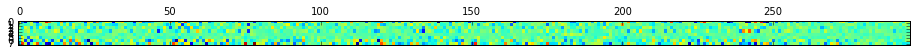

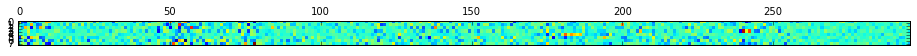

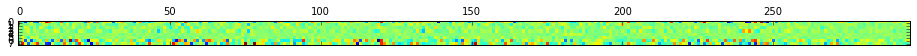

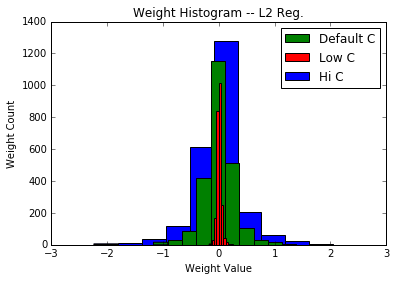

In [17]:
weights_defaultC = trained_model_defaultC.coef_
plt.matshow(weights_defaultC)

plt.figure()
weights_lowC = trained_model_lowC.coef_
plt.matshow(trained_model_lowC.coef_)

plt.figure()
weights_hiC = trained_model_hiC.coef_
plt.matshow(trained_model_hiC.coef_)


plt.figure()
l2 = plt.hist(weights_hiC.ravel(), bins=10);
l0 = plt.hist(weights_defaultC.ravel(), bins=10);
l1 = plt.hist(weights_lowC.ravel(), bins=10);
plt.legend([l0[2][0], l1[2][0], l2[2][0]], ['Default C', 'Low C', 'Hi C'])
plt.xlabel('Weight Value')
plt.ylabel('Weight Count')
plt.title('Weight Histogram -- L2 Reg.')


#the weights of the low C (more heavily regularized) classifier are more close to 0
#while weights of the hi C (more heavily regularized) classifier are more larger
# ... as expected

### Effect of regularization constant -- L1 regularization

In [18]:
#Let's compare what happens to the weights at different values of the regularization

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        5,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

results_defaultC_l1, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': 1,
                                                           'penalty': 'l1', 
                                                           'dual': False},
                                               return_models=True
                                              )

results_lowC_l1, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e-3,
                                                           'penalty': 'l1', 
                                                           'dual': False},
                                               return_models=True
                                              )

results_hiC_l1, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e3,
                                                           'penalty': 'l1', 
                                                           'dual': False},
                                               return_models=True
                                              )

trained_model_defaultC_l1 = results_defaultC_l1['models'][0]
trained_model_lowC_l1 = results_lowC_l1['models'][0]
trained_model_hiC_l1 = results_hiC_l1['models'][0]

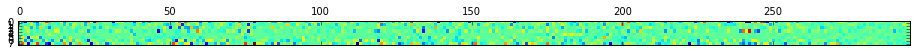

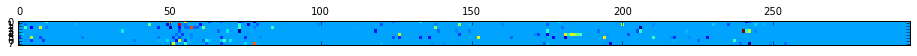

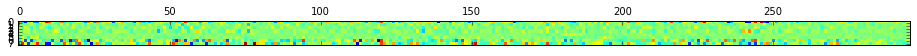

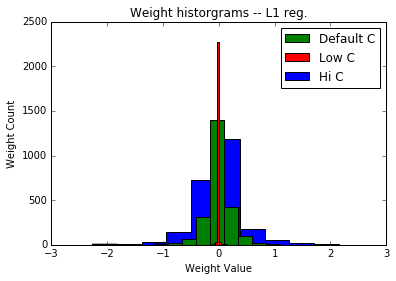

In [19]:
weights_defaultC_l1 = trained_model_defaultC_l1.coef_
plt.matshow(weights_defaultC_l1)

plt.figure()
weights_lowC_l1 = trained_model_lowC_l1.coef_
plt.matshow(trained_model_lowC_l1.coef_)

plt.figure()
weights_hiC_l1 = trained_model_hiC_l1.coef_
plt.matshow(trained_model_hiC_l1.coef_)


plt.figure()
l2 = plt.hist(weights_hiC_l1.ravel(), bins=10);
l0 = plt.hist(weights_defaultC_l1.ravel(), bins=10);
l1 = plt.hist(weights_lowC_l1.ravel(), bins=10);
plt.legend([l0[2][0], l1[2][0], l2[2][0]], ['Default C', 'Low C', 'Hi C'])
plt.xlabel('Weight Value')
plt.ylabel('Weight Count')
plt.title('Weight historgrams -- L1 reg.')


#the weights of the low C (more heavily regularized) classifier are more close to 0
#while weights of the hi C (more heavily regularized) classifier are more larger
# ... as expected

In [20]:
stats.kurtosis?

In [21]:
#check out kurtosis of weight distributio with L2-reg (C=5e-3)
stats.kurtosis(weights_lowC.ravel())

3.2815658559973233

In [22]:
#check out kurtosis of weight distributio with L1-reg (C=5e-3)
stats.kurtosis(weights_lowC_l1.ravel())

85.97650435632669

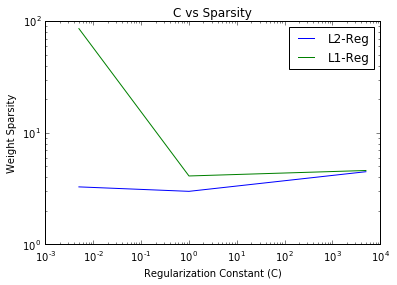

In [23]:
kurt = lambda x: stats.kurtosis(x.ravel())

kurtoses_l2 = map(kurt, [weights_lowC, weights_defaultC, weights_hiC])
kurtoses_l1 = map(kurt, [weights_lowC_l1, weights_defaultC_l1, weights_hiC_l1])

l0 = plt.plot([5e-3, 1, 5e3], kurtoses_l2)
l1 = plt.plot([5e-3, 1, 5e3], kurtoses_l1)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Regularization Constant (C)')
plt.ylabel('Weight Sparsity')
plt.title('C vs Sparsity')
plt.legend([l0[0], l1[0]], ['L2-Reg', 'L1-Reg'])

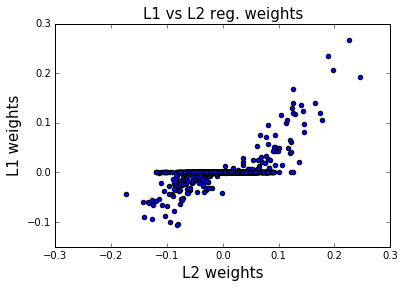

In [24]:
plt.scatter(weights_lowC.ravel(), 
            weights_lowC_l1.ravel())
plt.xlabel('L2 weights', fontsize=15)
plt.ylabel('L1 weights', fontsize=15)
plt.title('L1 vs L2 reg. weights', fontsize=15)

In [25]:
print(results_lowC_l1['test']['mean_accuracy'],
      results_defaultC_l1['test']['mean_accuracy'],
      results_hiC_l1['test']['mean_accuracy'])
      
print(results_lowC['test']['mean_accuracy'],
      results_defaultC['test']['mean_accuracy'],
      results_hiC['test']['mean_accuracy'])

(0.760625, 0.805, 0.771875)
(0.8568750000000002, 0.7781249999999998, 0.760625)


### Systematic Comparison Across Regularization Constant

In [26]:
#Let's look at performance (training AND testing) as a function of regularization constant
splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        5,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

cvals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 
         1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

def get_C_curve():
    results = {}
    for cval in cvals:
        print('Getting results for cval=%f' % cval)
        results[cval] = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': cval}
                                              )
    return results

In [27]:
results_C_curve = get_C_curve()

Getting results for cval=0.000000
Getting results for cval=0.000000
Getting results for cval=0.000001
Getting results for cval=0.000010
Getting results for cval=0.000100
Getting results for cval=0.001000
Getting results for cval=0.010000
Getting results for cval=0.100000
Getting results for cval=1.000000
Getting results for cval=10.000000
Getting results for cval=100.000000
Getting results for cval=1000.000000
Getting results for cval=10000.000000
Getting results for cval=100000.000000
Getting results for cval=1000000.000000
Getting results for cval=10000000.000000
Getting results for cval=100000000.000000


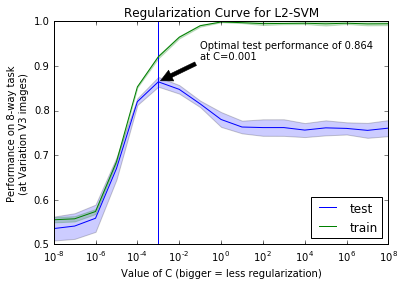

In [28]:
test_acc_curve = np.array([np.mean(results_C_curve[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])
test_acc_std = np.array([np.std(results_C_curve[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])

l0 = plt.semilogx(cvals, test_acc_curve)
plt.fill_between(cvals, test_acc_curve - test_acc_std, test_acc_curve + test_acc_std, alpha=.2)

optimal = test_acc_curve.argmax()
optperf = test_acc_curve.max()
plt.axvline(cvals[optimal])
plt.annotate('Optimal test performance of %.3f\nat C=%.3f' % (optperf, cvals[optimal]), 
             xy=(cvals[optimal], test_acc_curve[optimal]),
             xytext=(cvals[optimal]+.1, test_acc_curve[optimal]+.05),
             arrowprops=dict(linewidth=0.5, facecolor='black', shrink=0.05))
    

train_acc_curve = np.array([np.mean(results_C_curve[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])
train_acc_std = np.array([np.std(results_C_curve[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])

l1 = plt.semilogx(cvals, train_acc_curve)
plt.fill_between(cvals, train_acc_curve - train_acc_std, train_acc_curve + train_acc_std, alpha=.2, color='g')

plt.xlabel('Value of C (bigger = less regularization)')
plt.ylabel('Performance on 8-way task\n(at Variation V3 images)')
plt.legend([l0[0], l1[0]], ['test', 'train'], loc='lower right')
plt.title('Regularization Curve for L2-SVM')

#OK, we see that
#  (1) training and testing are both poor at very high levels of regularization (low C)
#  (2) training performance increases monotonically as regularization decreases, 
#      converging to ceiling levels at very high values of C
#  (3) overfitting (gap between green and blue) increases as regularization decreases
#  (4) most important: there is an *optimal* level of regularization from a testing perspective

In [29]:
#Let's look at performance (training AND testing) as a function of regularization constant
splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        5,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

cvals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 
         1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

def get_C_curve_l1():
    results = {}
    for cval in cvals:
        print('Getting results for cval=%f' % cval)
        results[cval] = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': cval,
                                                           'penalty': 'l1',
                                                           'dual': False}
                                              )
    return results

In [30]:
results_C_curve_l1 = get_C_curve_l1()

Getting results for cval=0.000000
Getting results for cval=0.000000
Getting results for cval=0.000001
Getting results for cval=0.000010
Getting results for cval=0.000100
Getting results for cval=0.001000
Getting results for cval=0.010000
Getting results for cval=0.100000
Getting results for cval=1.000000
Getting results for cval=10.000000
Getting results for cval=100.000000
Getting results for cval=1000.000000
Getting results for cval=10000.000000
Getting results for cval=100000.000000
Getting results for cval=1000000.000000
Getting results for cval=10000000.000000
Getting results for cval=100000000.000000


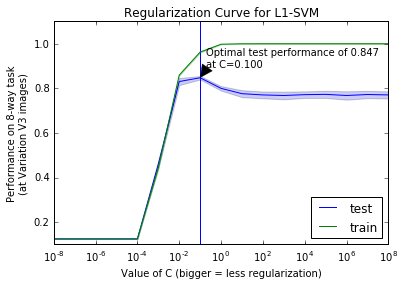

In [31]:
test_acc_curve_l1 = np.array([np.mean(results_C_curve_l1[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])
test_acc_std_l1 = np.array([np.std(results_C_curve_l1[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])

l0 = plt.semilogx(cvals, test_acc_curve_l1)
plt.fill_between(cvals, 
                 test_acc_curve_l1 - test_acc_std_l1, 
                 test_acc_curve_l1 + test_acc_std_l1, 
                 alpha=.2)

optimal = test_acc_curve_l1.argmax()
optperf = test_acc_curve_l1.max()

plt.axvline(cvals[optimal])
plt.annotate('Optimal test performance of %.3f\nat C=%.3f' % (optperf, cvals[optimal]), 
             xy=(cvals[optimal], test_acc_curve_l1[optimal]),
             xytext=(cvals[optimal]+.1, test_acc_curve_l1[optimal]+.05),
             arrowprops=dict(linewidth=0.5, facecolor='black', shrink=0.05))
    

train_acc_curve_l1 = np.array([np.mean(results_C_curve_l1[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])
train_acc_std_l1 = np.array([np.std(results_C_curve_l1[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])

l1 = plt.semilogx(cvals, train_acc_curve_l1)
plt.fill_between(cvals, 
                 train_acc_curve_l1 - train_acc_std_l1,
                 train_acc_curve_l1 + train_acc_std_l1, alpha=.2, color='g')

plt.xlabel('Value of C (bigger = less regularization)')
plt.ylabel('Performance on 8-way task\n(at Variation V3 images)')
plt.legend([l0[0], l1[0]], ['test', 'train'], loc='lower right')
plt.title('Regularization Curve for L1-SVM')

#OK, we see that
#  (1) training and testing are both poor at very high levels of regularization (low C)
#  (2) training performance increases monotonically as regularization decreases, 
#      converging to ceiling levels at very high values of C
#  (3) overfitting (gap between green and blue) increases as regularization decreases
#  (4) most important: there is an *optimal* level of regularization from a testing perspective

### Cross-Validating your regularization parameter

In [32]:
#let's use the built-in GridSearch facility to make it easy to do
#search for the C parameter

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        2,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

#ok notice that now instead of passing model_args#
#we're passing gridcv_params
gridCV_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LinearSVC,
                                 gridcv_params={'C': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
                                                      1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 
                                                      1e3, 1e4, 1e5, 1e6, 1e7, 1e8]},
                                 return_models=True
                                 )

In [33]:
#OK, how well do this do?
acc = gridCV_res[0]['test']['mean_accuracy']
print("Cross-validated search for C value accuracy: %.2f%%" % (100 * acc))
#ok not bad!
#And what value of C did it come up with? 
chosen_cvals = [_m.best_estimator_.C for _m in gridCV_res[0]['models']]
print('Chosen cvals:', chosen_cvals)
#Ah, it found the same one we did (1e-3) on both splits we tried

Cross-validated search for C value accuracy: 85.94%
('Chosen cvals:', [0.001, 0.001])


## Regularized Regression

In [34]:
#ok let's import the LinearRegression class (this is ordinary least squares regression)
from sklearn.linear_model import LinearRegression

In [35]:
def rsquared(predicted, actual):
    """The "rsquared" metric
    """
    a_mean = actual.mean()
    num = np.linalg.norm(actual - predicted)**2
    denom = np.linalg.norm(actual - a_mean)**2
    return 1 - num / denom


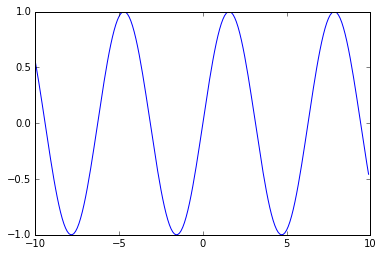

In [36]:
data = np.arange(-10, 10, .1)
plt.plot(data, np.sin(data))

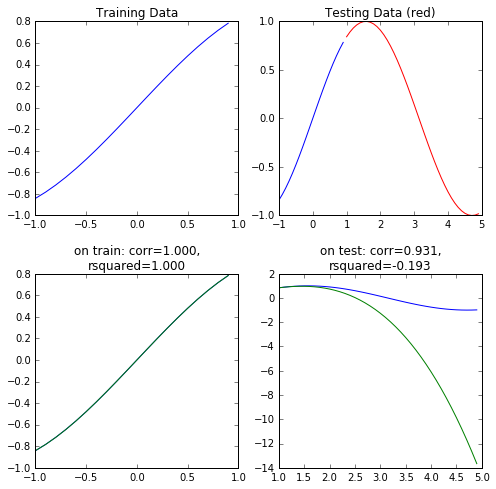

In [37]:
#Let's regress the sine function
func = np.sin

#we'll train on data range 1
data1 = np.arange(-1, 1, .1)
#and test on data range 2
data2 = np.arange(1, 5, .1)
y1 = func(data1)
y2 = func(data2)

#we'll allow predictors up to the 4th power e.g. 
#4th-order polynomials
polyorder = 4
regressors1 = np.array([data1**i for i in range(polyorder)]).T
regressors2 = np.array([data2**i for i in range(polyorder)]).T
#construct regressors all in one matrix and then subselect the data
#for the two ranges

#now let's fit the model 
model = LinearRegression()
model.fit(regressors1, y1)

#coefficients of the model recover the taylor series of func

#and get its predictions both on datarange 1 and datarange 2
predictions1 = model.predict(regressors1) #training data range
predictions2 = model.predict(regressors2) #testing data range

#and let's look at the correlation metric
corr1 = stats.pearsonr(y1, predictions1)[0]
corr2 = stats.pearsonr(y2, predictions2)[0]

#as well as the rsquared metric
rs1 = rsquared(y1, predictions1)
rs2 = rsquared(y2, predictions2)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(data1, y1)
plt.title('Training Data')
plt.subplot(2, 2, 2)
plt.plot(data1, y1)
plt.plot(data2, y2, color='r')
plt.title('Testing Data (red)')
plt.subplot(2, 2, 3)
plt.plot(data1, y1)
plt.plot(data1, predictions1)
plt.title('on train: corr=%.3f,\nrsquared=%.3f' % (corr1, rs1))
plt.subplot(2, 2, 4)
plt.plot(data2, y2)
plt.plot(data2, predictions2)
plt.title('on test: corr=%.3f,\nrsquared=%.3f' % (corr2, rs2))

plt.subplots_adjust(hspace=.3)

#the correlation metric is misleading. actually the rsquared metric is negative
#which means that the testing data it would have been better to pick the mean
#than to use the predictions here.  bad overfitting.  but not easily shown
#by looking at the correlation metric

In [38]:
def evaluate_regression_results(predicted, actual):
    """computing various useful metrics for regression results
    """
    result = {}
    if actual.ndim > 1: #this is triggered if the prediction is of multiple outputs at once
        result['pearson_array'] = np.array([stats.pearsonr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['spearman_array'] = np.array([stats.spearmanr(p, a)[0] for p, a in zip(predicted.T, actual.T)])
        result['rsquared_array'] = np.array([rsquared(p, a) for p, a in zip(predicted.T, actual.T)])
        result['pearson'] = np.median(result['pearson_array'])
        result['spearman'] = np.median(result['spearman_array'])
        result['rsquared'] = np.median(result['rsquared_array'])
    else:
        result['pearson'] = stats.pearsonr(predicted, actual)[0]
        result['spearman'] = stats.spearmanr(predicted, actual)[0]
        result['rsquared'] = rsquared(predicted, actual)
    return result

def aggregate_regression_results(results_by_split):
    """convenience function aggregating results of regression tests over data splits
    """
    results = {}
    results['by_split'] = results_by_split
    ns = len(results_by_split)
    for k in results_by_split[0]:
        arr = np.array([results_by_split[i][k] for i in range(ns)])
        if arr.ndim == 1:
            results['mean_' + k] = arr.mean()
            results['std_' + k] = arr.std()
        else:
            results['mean_' + k] = arr.mean(axis=0)
            results['std_' + k] = arr.std(axis=0)
    return results


In [39]:
def train_and_test_scikit_regressor(features, 
                                    labels,
                                    splits,
                                    model_class,
                                    model_args=None,
                                    gridcv_params=None,
                                    gridcv_args=None,
                                    fit_args=None,
                                    feature_norm=True,
                                    return_models=False
                                    ):
    """This function is very similar to the train_and_test_scikit_classifier function
       except it is adapted for working with regressors.
    """

    if model_args is None:
        model_args = {}
    if fit_args is None:
        fit_args = {}
    
    training_sidedata = []
   
    models = []
    train_results = []
    test_results = []
    
    for split in splits:

        #here we instantiate the general regressor whatever it is
        model = model_class(**model_args)
        if gridcv_params is not None:
            if gridcv_args is None:
                gridcv_args = {}
            model = GridSearchCV(model, gridcv_params, **gridcv_args)
            
        #get the train/test split data
        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        #train the model ...
        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        model.fit(train_features, train_labels, **fit_args)
        
        #... and get training predictions and results
        train_predictions = model.predict(train_features)
        train_result = evaluate_regression_results(train_predictions, train_labels)
        train_results.append(train_result)
             
        #test the model ... 
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
        #... and get testing predictions and results
        test_predictions = model.predict(test_features)
        test_result = evaluate_regression_results(test_predictions, test_labels)
        test_results.append(test_result)
        
        if return_models:
            models.append(model)
        
    #aggregate results over splits
    train_results = aggregate_regression_results(train_results)
    test_results = aggregate_regression_results(test_results)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results


In [40]:
from sklearn.linear_model import (Ridge, 
                                  RidgeCV, 
                                  Lasso, 
                                  LassoCV,
                                  ElasticNet, 
                                  ElasticNetCV, 
                                  OrthogonalMatchingPursuit)

from sklearn.kernel_ridge import KernelRidge

from sklearn.svm import SVR

In [41]:
def test_regression_method(features, model_class, model_args, key):
    splits = cv.get_splits(metadata=meta_array, 
                               split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                               num_splits=5,  
                               num_per_class_test=5,  
                               num_per_class_train=75,
                               train_filter=lambda x: x['variation_level'] != 'V0',
                               test_filter=lambda x: x['variation_level']  != 'V0'
                               )

    t0 = time.time()
    res = train_and_test_scikit_regressor(features=features, 
                                    labels=meta_array[key],
                                    splits=splits,
                                    model_class=model_class,
                                    model_args=model_args,
                                    feature_norm=False)
    t1 = time.time() - t0
    
    rval = res['test']['mean_pearson']
    rs = res['test']['mean_rsquared']
    cname = str(model_class)
    print('%s result on %s estimation: corr=%.3f, rsquared=%.3f; took %.3fs' % (cname, key, rval, rs, t1))    
    
    return res

In [45]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

import time

In [46]:
#ok let's check out the power of IT neural population data to regress y position 
#using a variety of regressor techniques
res_ols = test_regression_method(IT_Neural_Data, LinearRegression, None, 'translation_y')
res_ridge = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 'translation_y')
res_ridgecv = test_regression_method(IT_Neural_Data, RidgeCV, None, 'translation_y')
res_lassocv = test_regression_method(IT_Neural_Data, LassoCV, None, 'translation_y')
res_elasticnet = test_regression_method(IT_Neural_Data, ElasticNet, {'alpha':1e-3, 'l1_ratio': .5}, 'translation_y')
res_elasticnetcv = test_regression_method(IT_Neural_Data, ElasticNetCV, None, 'translation_y')
res_omp = test_regression_method(IT_Neural_Data, OrthogonalMatchingPursuit, None, 'translation_y')
res_svr = test_regression_method(IT_Neural_Data, SVR, {'C': 1e-1}, 'translation_y')
res_knr = test_regression_method(IT_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'translation_y')
#looks like ridge is nearly the best and quite fast
#kernel ridge is somewhat better but much slower
#all the others methods aren't better

<class 'sklearn.linear_model.base.LinearRegression'> result on translation_y estimation: corr=0.612, rsquared=0.372; took 0.307s
<class 'sklearn.linear_model.ridge.Ridge'> result on translation_y estimation: corr=0.612, rsquared=0.372; took 0.137s
<class 'sklearn.linear_model.ridge.RidgeCV'> result on translation_y estimation: corr=0.613, rsquared=0.374; took 0.711s
<class 'sklearn.linear_model.coordinate_descent.LassoCV'> result on translation_y estimation: corr=0.614, rsquared=0.375; took 3.652s
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> result on translation_y estimation: corr=0.614, rsquared=0.376; took 0.832s
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'> result on translation_y estimation: corr=0.614, rsquared=0.375; took 3.684s
<class 'sklearn.linear_model.omp.OrthogonalMatchingPursuit'> result on translation_y estimation: corr=0.592, rsquared=0.349; took 0.082s
<class 'sklearn.svm.classes.SVR'> result on translation_y estimation: corr=0.609, rs

In [47]:
#same conclusions for rotation around the xy axis
res_ols_rxy = test_regression_method(IT_Neural_Data, LinearRegression, None, 'rotation_xy')
res_ridge_rxy = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 'rotation_xy')
res_ridgecv_rxy = test_regression_method(IT_Neural_Data, RidgeCV, None, 'rotation_xy')
res_lassocv_rxy = test_regression_method(IT_Neural_Data, LassoCV, None, 'rotation_xy')
res_elasticnet_rxy = test_regression_method(IT_Neural_Data, ElasticNet, {'alpha':1e-3, 'l1_ratio': .5}, 'rotation_xy')
res_elasticnetcv_rxy = test_regression_method(IT_Neural_Data, ElasticNetCV, None, 'rotation_xy')
res_omp_rxy = test_regression_method(IT_Neural_Data, OrthogonalMatchingPursuit, None, 'rotation_xy')
res_svr_rxy = test_regression_method(IT_Neural_Data, SVR, {'C': 1e-1}, 'rotation_xy')
res_knr_rxy = test_regression_method(IT_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'rotation_xy')


<class 'sklearn.linear_model.base.LinearRegression'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 0.241s
<class 'sklearn.linear_model.ridge.Ridge'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 0.071s
<class 'sklearn.linear_model.ridge.RidgeCV'> result on rotation_xy estimation: corr=0.388, rsquared=0.147; took 0.613s
<class 'sklearn.linear_model.coordinate_descent.LassoCV'> result on rotation_xy estimation: corr=0.367, rsquared=0.130; took 3.665s
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> result on rotation_xy estimation: corr=0.386, rsquared=0.145; took 2.423s
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'> result on rotation_xy estimation: corr=0.383, rsquared=0.137; took 3.695s
<class 'sklearn.linear_model.omp.OrthogonalMatchingPursuit'> result on rotation_xy estimation: corr=0.336, rsquared=0.110; took 0.074s
<class 'sklearn.svm.classes.SVR'> result on rotation_xy estimation: corr=0.270, rsquared=0.019; to

In [48]:
#and similar for the size variable
res_ridge_size = test_regression_method(IT_Neural_Data, Ridge, {'alpha': 1e-3}, 
                                        'size')
res_knr_size = test_regression_method(IT_Neural_Data, KernelRidge, 
                                      {'alpha': 5e-2, 'kernel':'rbf'}, 'size')

<class 'sklearn.linear_model.ridge.Ridge'> result on size estimation: corr=0.634, rsquared=0.400; took 0.071s
<class 'sklearn.kernel_ridge.KernelRidge'> result on size estimation: corr=0.693, rsquared=0.479; took 8.949s


In [49]:
#ok let's check out the power of V4 neural population data to regress y position 
res_ridge_V4 = test_regression_method(V4_Neural_Data, Ridge, {'alpha': 1e-3}, 
                                                              'translation_y')
res_knr_V4 = test_regression_method(V4_Neural_Data, KernelRidge, {'alpha': 5e-2, 
                                                                  'kernel':'rbf'}, 
                                                                  'translation_y')
#Ok, so V4 is substantially less good at estimating y position than IT

<class 'sklearn.linear_model.ridge.Ridge'> result on translation_y estimation: corr=0.331, rsquared=0.105; took 0.060s
<class 'sklearn.kernel_ridge.KernelRidge'> result on translation_y estimation: corr=0.356, rsquared=0.113; took 8.949s


In [50]:
#and now let's look at V4's ability to regression xy rotation
res_ridge_V4_rxy = test_regression_method(V4_Neural_Data, Ridge, {'alpha': 1e-3}, 'rotation_xy')
res_knr_V4_rxy = test_regression_method(V4_Neural_Data, KernelRidge, {'alpha': 5e-2, 'kernel':'rbf'}, 'rotation_xy')
#and again IT is better than V4 for xy-rotation

<class 'sklearn.linear_model.ridge.Ridge'> result on rotation_xy estimation: corr=0.195, rsquared=0.030; took 0.061s
<class 'sklearn.kernel_ridge.KernelRidge'> result on rotation_xy estimation: corr=0.173, rsquared=-0.009; took 8.982s


In [51]:
"""
btw, this comparison showing that IT is better than V4 at linear regression of 
non-categorical ("category-orthogonal") properties is an important part of the results in:

Hong, Ha, Daniel LK Yamins, Najib J. Majaj, and James J. DiCarlo. 
"Explicit information for category-orthogonal object properties increases along the ventral stream." 
Nature neuroscience 19, no. 4 (2016): 613.
""";

In [52]:
### Regressing IT from V4 

In [53]:
reg_splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                           )

In [54]:
#Let's just look first at neuron 0
res_v4_to_it_neuron0 = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data[:, 0],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False)
res_v4_to_it_neuron0['test']['mean_pearson']

0.3605052207273588

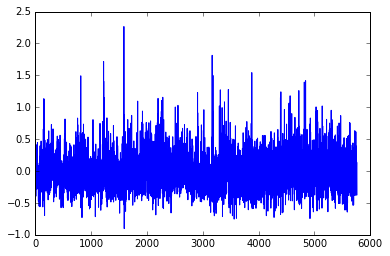

In [55]:
plt.plot(IT_Neural_Data[:, 0])

In [56]:
#ok so let's get all neurons from V4 to IT
res_V4_IT = [train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data[:, i],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False) for i in range(IT_Neural_Data.shape[1])]


In [57]:
#and from IT to V4
#this is not "physical" (or maybe it is?  recurrence?)
res_IT_V4 = [train_and_test_scikit_regressor(features=IT_Neural_Data, 
                                labels=V4_Neural_Data[:, i],
                                splits=reg_splits,
                                model_class=RidgeCV,
                                feature_norm=False) for i in range(V4_Neural_Data.shape[1])]


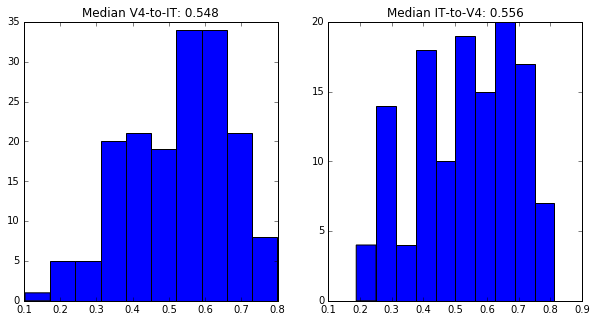

In [58]:
v4toit_ridgecv = [r['test']['mean_pearson'] for r in res_V4_IT]
ittov4_ridgecv = [r['test']['mean_pearson'] for r in res_IT_V4]
med_v4toit_ridgecv = np.median(v4toit_ridgecv) 
med_ittov4_ridgecv = np.median(ittov4_ridgecv) 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(v4toit_ridgecv)
plt.title('Median V4-to-IT: %.3f' % med_v4toit_ridgecv)
plt.subplot(1, 2, 2)
plt.hist(ittov4_ridgecv )
plt.title('Median IT-to-V4: %.3f' % med_ittov4_ridgecv)



In [59]:
def idfunc(x):
    return x

def pearsonr(a, b):
    return stats.pearsonr(a, b)[0]

def spearmanr(a, b):
    return stats.spearmanr(a, b)[0]

def split_half_correlation(datas_by_trial,
                           num_splits,
                           aggfunc=idfunc,
                           statfunc=pearsonr):
    """
    Similar to split-half calculation from lecture 2, 
    but now allowing various aggregation and statistical comparison 
    functions
    """
        
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        stats1 = []
        stats2 = []
        for data in datas_by_trial:
            #get total number of trials
            num_trials = data.shape[0]

            #construct a new permutation of the trial indices
            perm = random_number_generator.permutation(num_trials)

            #take the first num_trials/2 and second num_trials/2 pieces of the data
            first_half_of_trial_indices = perm[:num_trials / 2]
            second_half_of_trial_indices = perm[num_trials / 2: num_trials]

            #mean over trial dimension
            s1 = aggfunc(data[first_half_of_trial_indices].mean(axis=0))
            s2 = aggfunc(data[second_half_of_trial_indices].mean(axis=0))
            stats1.extend(s1)
            stats2.extend(s2)
        
        #compute the correlation between the means
        corrval = statfunc(np.array(stats1), 
                           np.array(stats2))
        #add to the list
        corrvals.append(corrval)
        
    return spearman_brown(np.array(corrvals), 2)

In [60]:
#prep the by-trial data
IT_Data_by_trial = {}
V4_Data_by_trial = {}
for vl in ['V0', 'V3', 'V6']:
    level_number = vl[-1]
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, IT_NEURONS]
    IT_Data_by_trial[vl] = arr.swapaxes(0, 1)
    arr = Ventral_Dataset['time_averaged']['variation_level_%s' % level_number][:, :, V4_NEURONS]
    V4_Data_by_trial[vl] = arr.swapaxes(0, 1)

In [63]:
split_half_IT  = np.array([split_half_correlation([IT_Data_by_trial[vl][:, :, i].T for vl in ['V3', 'V6']],
                           num_splits=50,
                           aggfunc=idfunc,
                           statfunc=pearsonr).mean() for i in range(len(IT_NEURONS))])

split_half_V4  = np.array([split_half_correlation([V4_Data_by_trial[vl][:, :, i].T for vl in ['V3', 'V6']],
                           num_splits=50,
                           aggfunc=idfunc,
                           statfunc=pearsonr).mean() for i in range(len(V4_NEURONS))])

(array([ 5.,  2.,  9.,  6., 10.,  6., 11., 18., 48., 53.]),
 array([0.04976566, 0.14236026, 0.23495486, 0.32754946, 0.42014405,
        0.51273865, 0.60533327, 0.69792783, 0.79052246, 0.883117  ,
        0.97571164], dtype=float32),
 <a list of 10 Patch objects>)

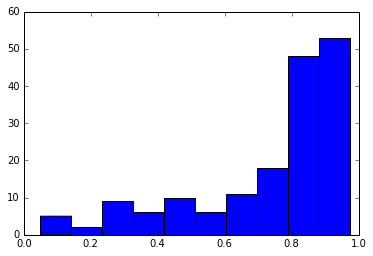

In [64]:
plt.hist(split_half_IT)

In [65]:
V4_IT_vec = np.array([r['test']['mean_pearson'] for r in res_V4_IT])
IT_V4_vec = np.array([r['test']['mean_pearson'] for r in res_IT_V4])

In [66]:
uncorrected = np.median(V4_IT_vec)
corrected = np.median(V4_IT_vec / split_half_IT)
print('V4-to-IT Uncorrected: %.3f; corrected: %.3f' % (uncorrected, corrected))

V4-to-IT Uncorrected: 0.548; corrected: 0.713


In [67]:
uncorrected = np.median(IT_V4_vec)
corrected = np.median(IT_V4_vec / split_half_V4)
print('IT-to-V4 Uncorrected: %.3f; corrected: %.3f' % (uncorrected, corrected))

IT-to-V4 Uncorrected: 0.556; corrected: 0.700


### PLS Regression

In [68]:
from sklearn.cross_decomposition import PLSRegression

In [69]:
#With PLS Regression we can do all the predictions at once
#instead of having to create a separate regressor for each IT neuron
res_V4_IT_pls = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data,
                                splits=reg_splits,
                                model_class=PLSRegression,
                                model_args={'n_components': 25},
                                feature_norm=False)

res_V4_IT_pls['test']['mean_pearson']

0.5397649357541774

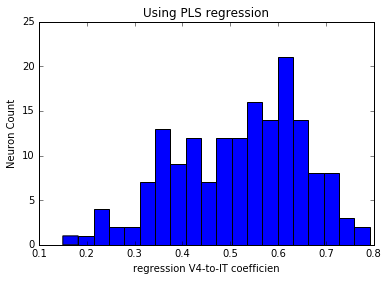

In [70]:
#so that's why this array of results is defined:
res_V4_IT_pls['test']['mean_pearson_array'].shape
plt.hist(res_V4_IT_pls['test']['mean_pearson_array'], bins=20)
plt.xlabel('regression V4-to-IT coefficien')
plt.ylabel('Neuron Count')
plt.title('Using PLS regression')

In [71]:
#let's actually analyze one trained model
one_split = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=1,  
                           num_per_class_test=5,  
                           num_per_class_train=75,
                           train_filter=lambda x: x['variation_level'] in ['V3', 'V6'],
                           test_filter=lambda x: x['variation_level'] in ['V3', 'V6']
                           )

res_V4_IT_pls_model = train_and_test_scikit_regressor(features=V4_Neural_Data, 
                                labels=IT_Neural_Data,
                                splits=one_split,
                                model_class=PLSRegression,
                                model_args={'n_components': 25, 'scale': False},
                                feature_norm=False,
                                return_models=True)

pls_model = res_V4_IT_pls_model['models'][0]

In [72]:
#Ok, so lets get the weights of the trained model
W = pls_model.coef_
W.shape
#see, this is the transform from V4 space (128 dim) to IT space (168) dimension

(128, 168)

In [73]:
#now let's compute the projection
IT_Neural_Data_guess = np.dot(V4_Neural_Data, W)
#has the right shape 
IT_Neural_Data_guess.shape

(5760, 168)

In [74]:
IT_Neural_Data_guess[:, 0]

array([-0.04941157, -0.07605215,  0.06652948, ..., -0.08312364,
       -0.06397824,  0.10168661])

In [75]:
IT_Neural_Data_guess1 = pls_model.predict(V4_Neural_Data)
IT_Neural_Data_guess1[:, 0]
#so exactly, the prediction is done by the above mechanism

array([-0.04933132, -0.0759719 ,  0.06660973, ..., -0.08304339,
       -0.06389799,  0.10176686])